In [1]:
import pandas as pd
import math
from collections import defaultdict
from tqdm import tqdm

In [2]:
train_data = pd.read_csv('train.csv')
valid_data = pd.read_csv('valid.csv')
test_data = pd.read_csv('test.csv')

In [3]:
print(len(train_data), len(valid_data), len(test_data))

905894 113236 113237


In [4]:
train_data = pd.concat([train_data, valid_data], ignore_index=True)

In [5]:
# let's only use 1/10 of the train data
# train_data = train_data.sample(frac=0.1, random_state=42)

In [6]:
usersPerItem = defaultdict(set)
itemsPerUser = defaultdict(set)
itemSet = set([])
ratingDict = {}
meanRating = 0

for j in range(len(train_data)):
  u,i,r = train_data['user'][j], train_data['item'][j], train_data['rating'][j]
  if i not in itemSet:
        itemSet.add(i)
  itemsPerUser[u].add(i)
  usersPerItem[i].add(u)
  ratingDict[u,i] = r
  meanRating += r

meanRating/=len(train_data)
print(meanRating)

4.411299834172284


In [7]:
def jaccard(s1, s2):
  if len(s1) == 0 or len(s2) == 0:
    return 0
  return len(s1.intersection(s2))/len(s1.union(s2))

In [8]:
from functools import cache

@cache
def cosineUser(u1, u2):
    # sum over intersection of items
    common_items = itemsPerUser[u1].intersection(itemsPerUser[u2])
    numerator = sum(ratingDict[u1,i]*ratingDict[u2,i] for i in common_items)
    denominator = math.sqrt(sum(ratingDict[u1,i]**2 for i in common_items))*math.sqrt(sum(ratingDict[u2,i]**2 for i in common_items))
    return numerator/denominator if denominator != 0 else 0

@cache 
def cosineItem(i1, i2):
    # sum over intersection of users
    common_users = usersPerItem[i1].intersection(usersPerItem[i2])
    numerator = sum(ratingDict[u,i1]*ratingDict[u,i2] for u in common_users)
    denominator = math.sqrt(sum(ratingDict[u,i1]**2 for u in common_users))*math.sqrt(sum(ratingDict[u,i2]**2 for u in common_users))
    return numerator/denominator if denominator != 0 else 0

@cache
def mean(u):
    return sum(ratingDict[u,i] for i in itemsPerUser[u])/len(itemsPerUser[u])

@cache
def pearsonUser(u1, u2):
    # sum over intersection of items
    common_items = itemsPerUser[u1].intersection(itemsPerUser[u2])
    numerator = sum((ratingDict[u1,i]-mean(u1))*(ratingDict[u2,i]-mean(u2)) for i in common_items)
    denominator = math.sqrt(sum((ratingDict[u1,i]-mean(u1))**2 for i in common_items))*math.sqrt(sum((ratingDict[u2,i]-mean(u2))**2 for i in common_items))
    return numerator/denominator if denominator != 0 else 0

In [13]:
test_rating = {}
mse = 0

for j in tqdm(range(len(test_data))):
    u,i,r = test_data['user'][j],test_data['item'][j],test_data['rating'][j]
    numerator = 0
    denominator = 0
    pred = meanRating

    if len(itemsPerUser[u]) != 0:
        for user in usersPerItem[i]:
            if user != u:
                sim = jaccard(itemsPerUser[user],itemsPerUser[u])
                numerator += sim * ratingDict[user,i]
                denominator += sim
        
        pred = meanRating
        if denominator != 0 :
            pred = numerator/denominator

    test_rating[u,i] = (r,pred)
    mse+=(r - pred)**2

mse/=len(test_data)
print(mse) 

1.7357767163829891


In [14]:
test_rating = {}
mse = 0

for j in tqdm(range(len(test_data))):
    u,i,r = test_data['user'][j],test_data['item'][j],test_data['rating'][j]
    numerator = 0
    denominator = 0
    pred = meanRating

    # item-based
    if len(itemsPerUser[u]) != 0:
        for item in itemsPerUser[u]:
            if item != i:
                sim = jaccard(usersPerItem[item],usersPerItem[i])
                numerator += sim * ratingDict[u,item]
                denominator += sim
        
        pred = meanRating
        if denominator != 0 :
            pred = numerator/denominator

    test_rating[u,i] = (r,pred)
    mse+=(r - pred)**2

mse/=len(test_data)
print(mse) 

1.6544342830769525


In [9]:
test_rating = {}
mse = 0

for j in tqdm(range(len(test_data))):
    u,i,r = test_data['user'][j],test_data['item'][j],test_data['rating'][j]
    numerator = 0
    denominator = 0
    pred = meanRating

    # item-based
    if len(itemsPerUser[u]) != 0:
        for item in itemsPerUser[u]:
            if item != i:
                sim = cosineItem(item,i)
                numerator += sim * ratingDict[u,item]
                denominator += sim
        
        pred = meanRating
        if denominator != 0 :
            pred = numerator/denominator

    test_rating[u,i] = (r,pred)
    mse+=(r - pred)**2

mse/=len(test_data)
print(mse) 

  0%|          | 0/113237 [00:00<?, ?it/s]

100%|██████████| 113237/113237 [02:50<00:00, 664.08it/s]

1.6365000331996853


(array([4.0800e+02, 2.0000e+00, 6.0000e+00, 2.0000e+00, 8.4000e+01,
        1.0000e+00, 1.1000e+01, 2.5000e+01, 2.8000e+01, 1.5400e+02,
        1.5000e+01, 4.5000e+01, 2.7100e+02, 7.1000e+01, 4.4600e+02,
        1.1700e+02, 4.0000e+02, 5.1600e+02, 9.0900e+02, 2.9430e+03,
        1.9720e+03, 4.0400e+03, 5.2168e+04, 1.3836e+04, 3.4767e+04]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
        2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ]),
 <BarContainer object of 25 artists>)

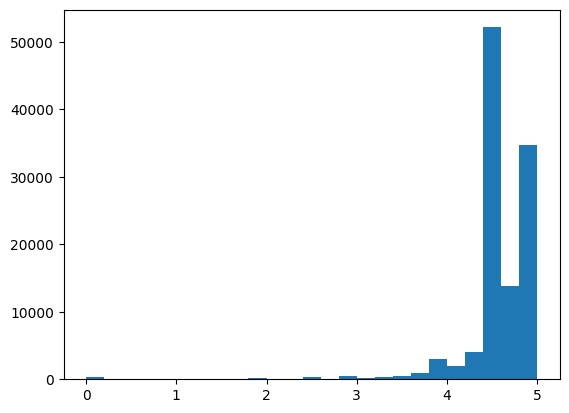

In [19]:
preds = [pred for r, pred in test_rating.values()]
import matplotlib.pyplot as plt
plt.hist(preds, bins=25)

In [10]:
test_rating = {}
mse = 0

for j in tqdm(range(len(test_data))):
    u,i,r = test_data['user'][j],test_data['item'][j],test_data['rating'][j]
    numerator = 0
    denominator = 0
    pred = meanRating

    if len(itemsPerUser[u]) != 0:
        for user in usersPerItem[i]:
            if user != u:
                sim = cosineUser(user,u)
                numerator += sim * ratingDict[user,i]
                denominator += sim
        
        pred = meanRating
        if denominator != 0 :
            pred = numerator/denominator

    test_rating[u,i] = (r,pred)
    mse+=(r - pred)**2

mse/=len(test_data)
print(mse) 

  0%|          | 0/113237 [00:00<?, ?it/s]

100%|██████████| 113237/113237 [00:21<00:00, 5330.29it/s]

1.6988795432523276


In [9]:
test_rating = {}
mse = 0

for j in tqdm(range(len(test_data))):
    u,i,r = test_data['user'][j],test_data['item'][j],test_data['rating'][j]
    numerator = 0
    denominator = 0
    pred = meanRating

    if len(itemsPerUser[u]) != 0:
        for user in usersPerItem[i]:
            if user != u:
                sim = pearsonUser(user,u)
                numerator += sim * ratingDict[user,i]
                denominator += sim
        
        pred = meanRating
        if denominator != 0 :
            pred = numerator/denominator

    test_rating[u,i] = (r,pred)
    mse+=(r - pred)**2

mse/=len(test_data)
print(mse) 

100%|██████████| 113237/113237 [00:22<00:00, 4967.67it/s]

5.074139915944861e+28


In [8]:
# naive baseline
test_rating = {}
mse = 0

for j in range(len(test_data)):
    u,i,r = test_data['user'][j],test_data['item'][j],test_data['rating'][j]
    numerator = 0
    denominator = 0
    pred = meanRating

    test_rating[u,i] = (r,pred)
    mse+=(r - pred)**2

mse/=len(test_data)
print(mse) 

1.5945964994326234
